# Exercise 7: Modeling composite materials

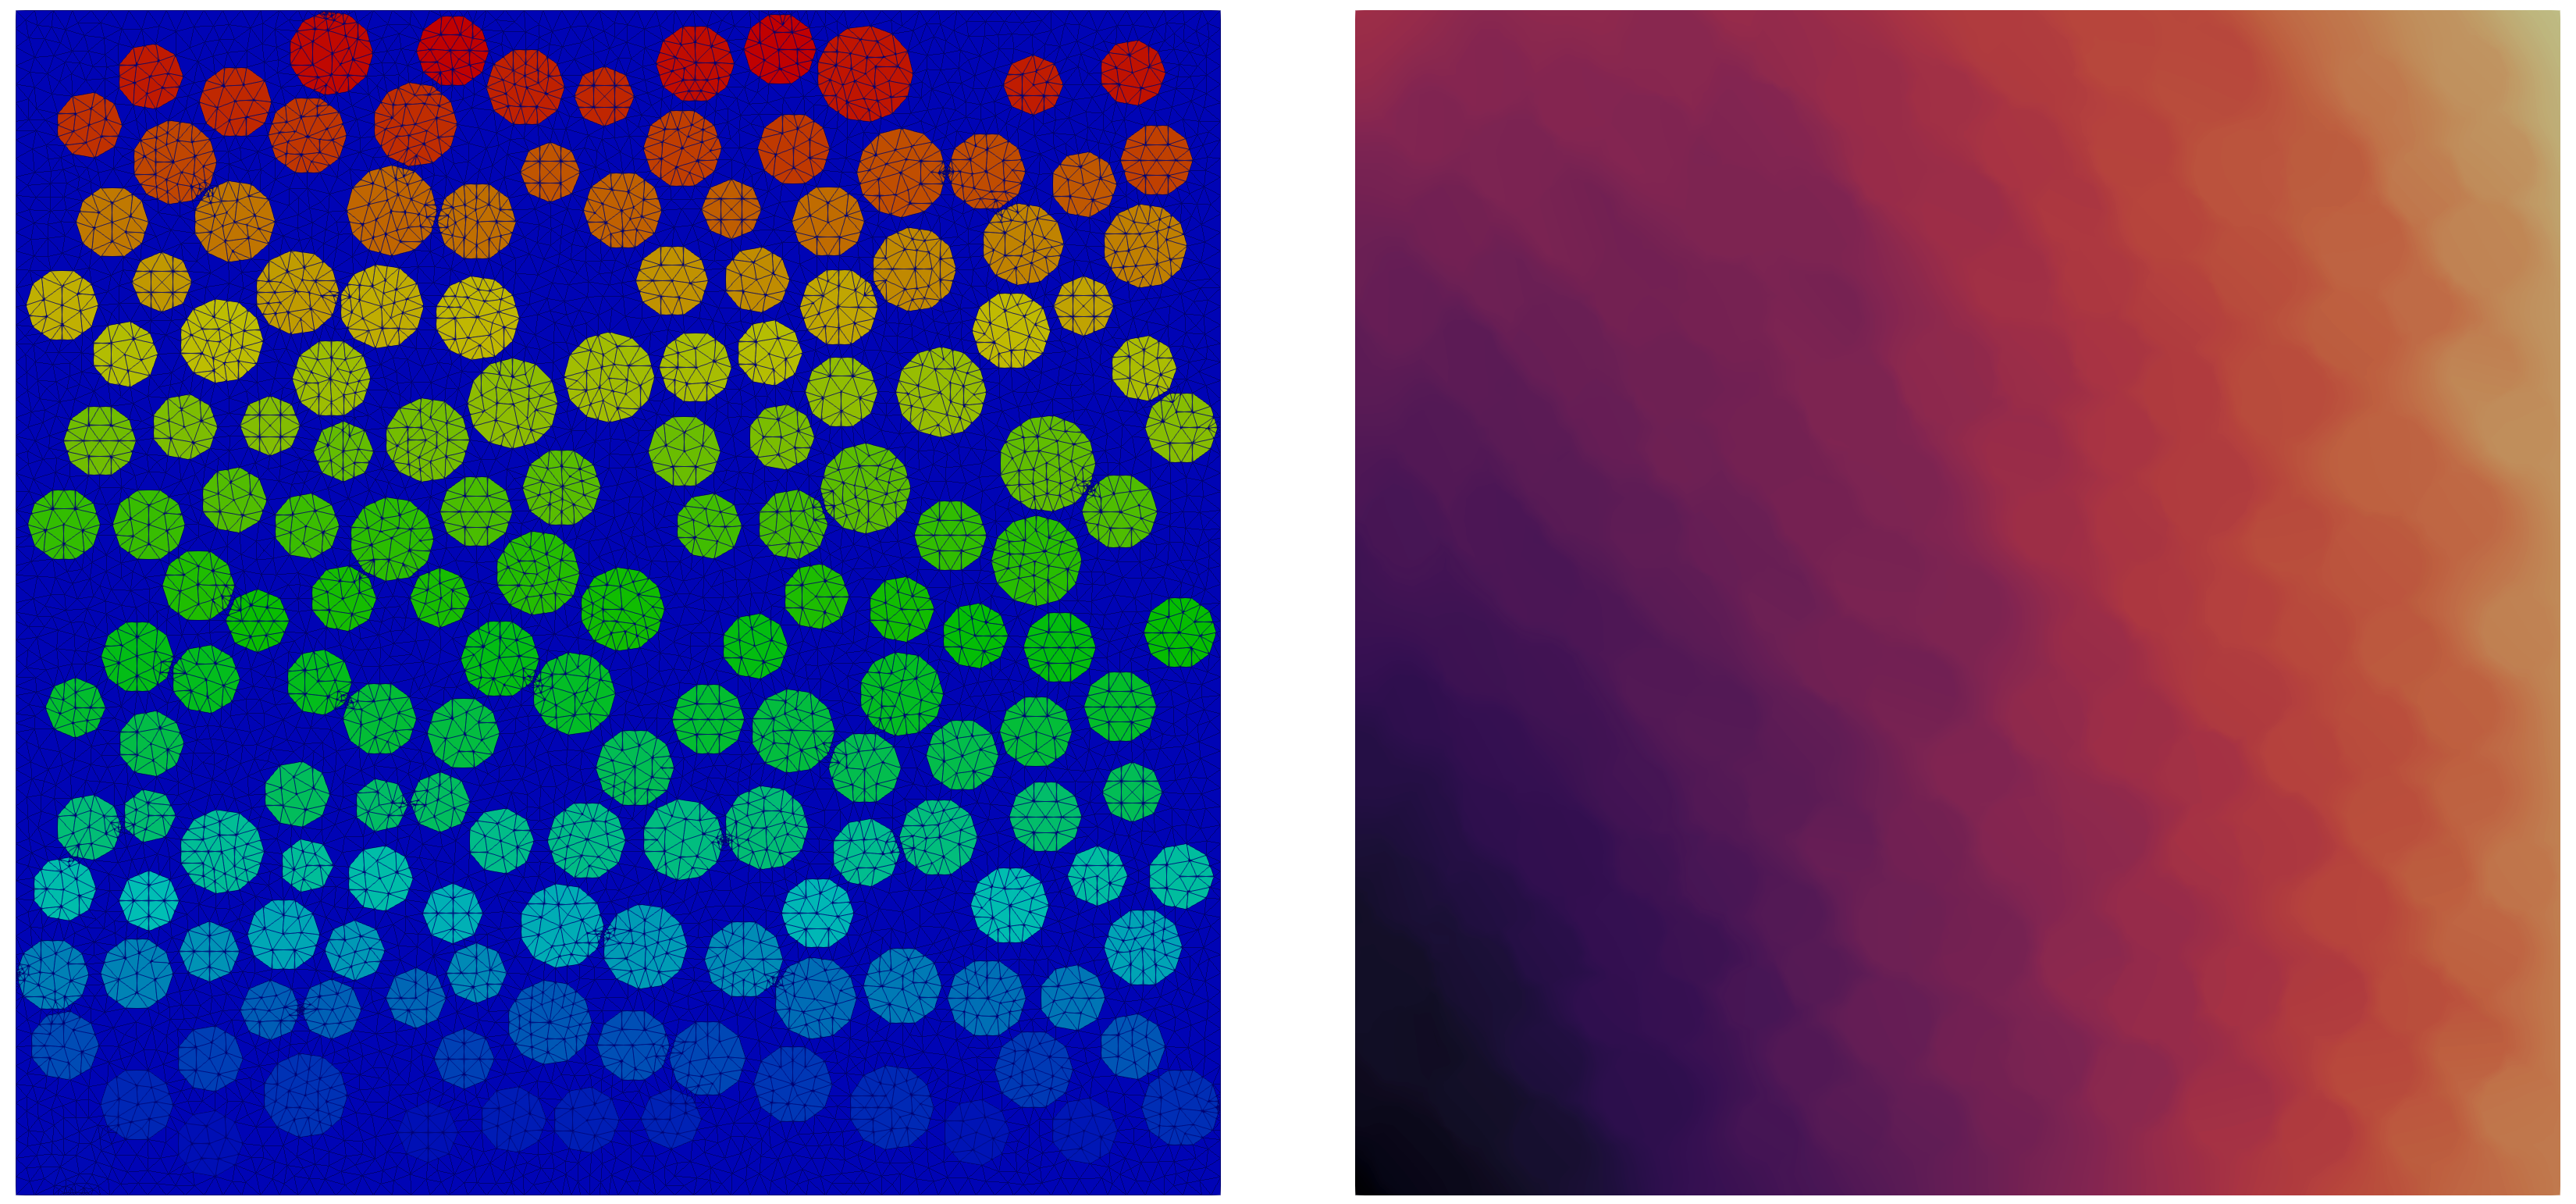

In this exercise, we will compute the effective material stiffness and effective Poisson's ratio of a composite material. The domain $\Omega$ is a 2D cross-section in the $xy$-plane of a set of cylindrical fibers (going in the $z$-direction) embedded in a surrounding material (matrix). We model the material by dividing the domain $\Omega$ into two different domains, the matrix (background) domain $\Omega_0$ and the fiber domain $\Omega_1$, with different material parameters in the two domains.

Just like in Exercise 5a, we will solve the equations of linear elasticity:
\begin{align}
-\mathrm{div}\,\sigma(u) = f. \\
\end{align}

The stress tensor $\sigma = \sigma(u)$ is given by
$$
\sigma(u) = 2\mu\epsilon(u) + \lambda \mathrm{tr}\,\epsilon(u) I,
$$

where $\epsilon(u) = \frac{1}{2}(\mathrm{grad}\,u + (\mathrm{grad}\,u)^{\top})$ is the symmetric gradient and $I$ is the identity matrix. The Lamé parameters are
\begin{align}
\mu &= \frac{E}{2\cdot(1 + \nu)}, \\
\lambda &= \frac{E\nu}{(1 + \nu)(1 - 2\nu)}.
\end{align}

Note that this 2D problem is identical to the 3D linear elastic problem in the case of [plane strain](https://en.wikipedia.org/wiki/Infinitesimal_strain_theory#Plane_strain).

The parameters $E$ and $\nu$ will have different values in $\Omega_0$ and $\Omega_1$.

We will use the following data:

* $E_0 = 3\,\mathrm{[GPa]}$ (Young's modulus in $\Omega_0$)
* $E_1 = 80\,\mathrm{[GPa]}$ (Young's modulus in $\Omega_1$)
* $\nu_0 = 0.4$ (Poisson's ratio in the matrix)
* $\nu_1 = 0.2$ (Poisson's ratio in the fibers)
* Fiber locations given by the file `Ex3-Fibers.txt`
* $u_x = 0$ on the left boundary
* $u_x = \delta$ on the right boundary
* $u_y = 0$ in the lower left corner

We will scale the Young's moduli to `3` and `80` (rather than `3e9` and `80e9`) for numerical stability. Remember that most numerical sofware and number systems perform better when all numbers are close `1`.

## Importing FEniCS
The first thing we need to do is to import FEniCS.

In [1]:
try:
    from fenics import *
except ImportError:
    !conda install -c conda-forge fenics -y
    from fenics import *
try:
    from mshr import *
except ImportError:
    !conda install -c conda-forge mshr -y
    from mshr import *

## Initializing notebook plotting
When running in a Jupyter notebook, a special line is necessary to show FEniCS plots in the notebook.

In [2]:
%matplotlib inline

## Loading the fiber coordinates
Before creating the mesh, we need to load the fiber coordinates from the text file `Ex3-Fibers.txt`. The file is a so-called CSV file (comma-separated values). Use the `loadtxt()` command from `numpy` to load the data into an array. Each row in the array will give the center coordinates $(x, y)$ and the radius $r$ for a fiber. Store the coordinates and radii in three arrays named `cx`, `cy` and `cr`.

In [3]:
from numpy import loadtxt
fibers = loadtxt('Ex3-Fibers.txt')
cx = fibers[:, 0]
cy = fibers[:, 1]
cr = fibers[:, 2]
print(fibers)

[[ 6.001447  5.034437  3.25    ]
 [16.985958  6.019035  2.75    ]
 [34.966783  6.943401  2.5     ]
 [80.152196  6.933722  2.75    ]
 [89.039734  7.061682  2.75    ]
 [41.995393  7.990612  2.75    ]
 [47.996703  7.964242  2.75    ]
 [55.0148    8.048407  2.5     ]
 [10.996202  9.206415  3.      ]
 [73.151207  8.983816  3.5     ]
 [97.        9.        3.25    ]
 [24.867563  9.985847  3.5     ]
 [65.043142 10.900814  3.25    ]
 [84.877569 12.095883  3.25    ]
 [17.       13.        2.75    ]
 [37.967763 12.995392  2.5     ]
 [58.004052 13.024101  3.25    ]
 [ 5.022265 14.083219  3.      ]
 [51.903346 14.104241  3.      ]
 [93.001726 13.995285  2.75    ]
 [44.999375 15.998124  3.5     ]
 [22.       17.        2.5     ]
 [27.020804 17.081191  2.5     ]
 [34.       18.001358  2.5     ]
 [66.895852 17.992675  3.75    ]
 [81.00828  17.987303  3.25    ]
 [88.037404 18.020709  2.75    ]
 [74.071478 18.994232  3.25    ]
 [ 4.060547 19.911699  3.      ]
 [11.000047 20.011624  3.      ]
 [38.98520

## Creating the mesh

In order for the fibers not to overlap, compute the number `feps` as `0.01` times the average fiber radius and then make sure that the distance between any two fibers is at least `feps`. Also use `feps` to expand the size of the enclosing domain so as not to touch the fibers.

Use FEniCS `mshr` to create the mesh. Figure out the dimensions of the fiber sample by computing $x_{\mathrm{min}} = \min(x - r)$ and similarly $x_{\mathrm{max}}$, $y_{\mathrm{min}}$ and $y_{\mathrm{max}}$. Create a rectangle using these coordinates and mark each fiber as a subdomain (`1`, `2`, `3`, ...) using the `set_subdomain()` command. See the section on [generating meshes with subdomains](https://fenicsproject.org/pub/tutorial/sphinx1/._ftut1005.html#generating-meshes-with-subdomains) in the [FEniCS Tutorial](https://fenicsproject.org/tutorial/) for details.

Use a resolution of $m = 64$ for the mesh generation. Note that it may take some time to generate the mesh so you might want to start with $m = 16$.

Also note that we will use the original scaling of the fiber coordinates. The actual dimension of the fiber sample is ca $16\,\mu\mathrm{m}$, but since the scaling of the domain is not relevant to the computation of the effective material stiffness and Poisson's ratio, we will keep the original scaling.

In [5]:
from mshr import *
from numpy import mean

# Compute feps as 0.01 times the average fiber radius
feps = 0.01*mean(cr)

# Make sure that the distance between all fiber pairs is at least feps
for i in range(len(cr)):
    for j in range(i + 1, len(cr)):
        d = sqrt((cx[i] - cx[j])**2 + (cy[i] - cy[j])**2)
        if d - feps < cr[i] + cr[j]:
            cr[i] = d - feps - cr[j]

# Compute xmin, xmax, ymin, ymax
xmin = min(cx - cr) - feps
xmax = max(cx + cr) + feps
ymin = min(cy - cr) - feps
ymax = max(cy + cr) + feps

# Define the background domain
domain = Rectangle(Point(xmin, ymin), Point(xmax, ymax))

# Mark the fibers
for i, (x, y, r) in enumerate(fibers):
    circle = Circle(Point(x, y), r)
    domain.set_subdomain(i + 1, circle)

# Generate the mesh
m = 64
mesh = generate_mesh(domain, m)

## Creating domain markers
Use a `MeshFunction` to create markers for the subdomains of the mesh. Since we only need two subdomains (the default value `0` for the matrix and `1` for the fibers) we modify the markers to either `0` or `1`. Use the domain markers to define an integration measure `dx` connected to the markers.

Use the integration measure to compute the volume fraction of fibers in the domain as the integral of `1*dx(1)` divided by the integral of `1*dx` (which is identical to `1*(dx(0) + dx(1))`. The integrals can be computed using the `assemble()` function in FEniCS.

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Vf = 0.4591017014027414


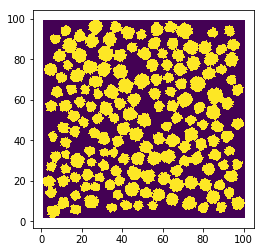

In [6]:
# Create MeshFunction for domain markers
domain_markers = MeshFunction('size_t', mesh, 2, mesh.domains())

# Mark all fiber domains as 1
for i in range(domain_markers.size()):
    if domain_markers[i] > 0:
        domain_markers[i] = 1
        
# Plot and save the markers to file for inspection
plot(domain_markers)
File('exercise7/domain_markers.pvd') << domain_markers

# Create integration measure dx connected to the markers
dx = Measure('dx', domain=mesh, subdomain_data=domain_markers)

# Compute the volume fraction
Vf = assemble(1*dx(1)) / assemble(1*dx)
print('Vf =', Vf)

## Setting problem parameters
We will use the following problem parameters.

In [7]:
E0 = 3        # Young's modulus in domain 0 (matrix)
E1 = 80       # Young's modulus in domain 1 (fibers)
nu0 = 0.4     # Poisson's ratio in domain 0 (matrix)
nu1 = 0.2     # Poisson's ratio in domain 1 (fibers)
strain = 0.01 # Strain (relative displacement)

## Defining the finite element function space
When we have loaded the mesh, we can define the finite element function space. We will use a piecewise quadratic $P_2$ function space. Since the displacement is vector-valued, we will need to create a `VectorFunctionSpace`.

In [8]:
V = VectorFunctionSpace(mesh, 'P', 2)

## Defining the boundary conditions
The three boundary conditions can be defined by using the `DirichletBC` class in combination with either FEniCS `SubDomain` classes or by directly specifying expressions for the boundary conditions, for example `'near(x[0], %.16g) % xmin'`. Note that for the point-wise boundary condition at the lower left corner one needs to specify the additional argument `'pointwise'`.

Use `V.sub(0)` and `V.sub(1)` to set boundary conditions separately for the $u_x$ and $u_y$ displacement components.

In [9]:
bc0 = DirichletBC(V.sub(0), 0, 'near(x[0], %.16g)' % xmin)
bc1 = DirichletBC(V.sub(1), 0, 'near(x[0], %.16g) && near(x[1], %.16g)' % (xmin, ymin), 'pointwise')
bc2 = DirichletBC(V.sub(0), strain*(xmax - xmin), 'near(x[0], %.16g)' % xmax)
bcs = [bc0, bc1, bc2]

## Defining the variational problem
The finite element variational problem for the linear elasticy problem reads: Find $u \in V$ such that
$$
\int_{\Omega_0} \sigma_0(u) : \varepsilon(v) \,\mathrm{d}x +
\int_{\Omega_1} \sigma_1(u) : \varepsilon(v) \,\mathrm{d}x
=
\int_{\Omega} f \cdot v \,\mathrm{d}x
$$
for all $v \in V$.

This can be expressed in FEniCS by defining the *bilinear form* $a$ and the *linear form* $L$:

\begin{align}
  a(u, v) &= \int_{\Omega_0} \sigma_0(u) : \varepsilon(v) \,\mathrm{d}x + \int_{\Omega_1} \sigma_1(u) : \varepsilon(v) \,\mathrm{d}x, \\
  L(v) &= \int_{\Omega} f \cdot v \,\mathrm{d}x,
\end{align}

where $\sigma_0(u)$ and $\sigma_1(u)$ are two different expressions for the stress tensor depending on the different material parameters for the two domains $\Omega_0$ and $\Omega_1$. These domains are the matrix domain (marked as `0`) and the fiber domain (marked as `1`).

The two integration domains can be expressed in FEniCS as `dx(0)` and `dx(1)`.

In [10]:
def epsilon(u):
    return sym(grad(u))

def sigma(u, E, nu):
    mu = E / (2.0*(1.0 + nu))
    lmbda = E*nu / ((1.0 + nu)*(1.0 - 2.0*nu))
    return 2.0*mu*epsilon(u) + lmbda*tr(epsilon(u))*Identity(2)

u = TrialFunction(V)
v = TestFunction(V)
f = Constant((0, 0))
a = inner(sigma(u, E0, nu0), grad(v))*dx(0) + inner(sigma(u, E1, nu1), grad(v))*dx(1)
L = dot(f, v)*dx

## Solving the variational problem
The variational problem can now be solved by calling the FEniCS `solve` command. Use the `plot` command to visualize the solution. Use a new variable `u_h` to store the solution (rather than overwriting the trial function `u`) since we will make use of both `u` and `u_h` below...

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


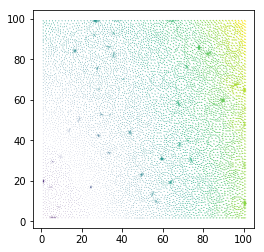

In [11]:
u_h = Function(V)
solve(a == L, u_h, bcs)
plot(u_h)

## Computing the reaction force
To compute the effective material stiffness, we note that if $-\nabla\cdot u = f$ in a domain $\Omega$, then it follows from integration by parts that
$$
\int_{\Omega} \sigma(u):\varepsilon(v) \,\mathrm{d}x 
= \int_{\partial\Omega} g \cdot v \,\mathrm{d}s
+ \int_{\Omega} f \cdot v \,\mathrm{d}x,
$$
where $g = \sigma\cdot n$ is the *boundary traction*. Note that this holds for any (differentiable) function $v$.

To compute the reaction force $F$ on the left boundary $\Gamma_{\mathrm{L}}$, we note that if $f = 0$ and $\psi$ is a function that is equal to $(1, 0)$ on $\Gamma_{\mathrm{L}}$ and zero on the remaining boundary, then
$$
F = \int_{\Gamma_{\mathrm{L}}} (\sigma\cdot n) \cdot (-1,0) \,\mathrm{d}s
= -\int_{\partial\Omega} g \cdot \psi \,\mathrm{d}s
= -\int_{\Omega} \sigma(u):\varepsilon(\psi) \,\mathrm{d}x.
$$
In other words, the reaction force on the boundary can be computed by an integral of the stress over the domain weighted by the strain of the function $\psi$.

Alternatively, the reaction force may be computed by noting that if $\mathcal{I}$ is the set of indices for the nodes
on the left boundary $\Gamma_{\mathrm{L}}$ related to the $x$-component of the finite element solution, then the function $\psi$ can be expressed as
$$
\psi(x) = \sum_{i\in\mathcal{I}} \phi_i(x).
$$
It follows that
$$
F
= -\int_{\Omega} \sigma(u):\varepsilon(\psi) \,\mathrm{d}x
= -\int_{\Omega} \sigma\left(\sum_{j=1}^N U_j \phi_j\right):\varepsilon\left(\sum_{i\in\mathcal{I}}\phi_i\right) \,\mathrm{d}x
= -\sum_{i\in\mathcal{I}} \sum_{j=1}^N U_j \int_{\Omega} \sigma(\phi_j):\varepsilon(\phi_i) \,\mathrm{d}x
= -\sum_{i\in\mathcal{I}} (AU)_i,
$$
where $A$ is the stiffness matrix and $U$ is the vector of degrees of freedom for the computed solution. We may thus compute the reaction force by applying the stiffness matrix (before application of boundary conditions!) to the solution vector $U$ and then sum over the rows corresponding to the normal component degrees of freedom on the left boundary.

Note that both alternatives should yield the same result for the reaction force (to within machine precision).

The function $\psi$ may be constructed in FEniCS by creating a vector-valued function in the function space $V$ and setting the value on the left boundary to $(1, 0)$ using a `DirichletBC` applied to the vector $\Psi$ of degrees of freedom for the function $\psi$. Summing over the degrees of freedom on the boundary may be expressed by taking the inner product of the vector $AU$ with the degrees of freedom $\Psi$ of the function $\psi$.

Calling FFC just-in-time (JIT) compiler, this may take some time.
F1 = 9.119101736994807
F2 = 9.119101736994773


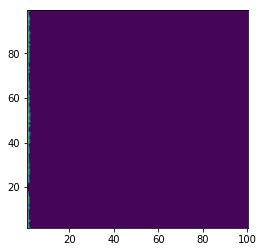

In [12]:
# Create the finite element function psi
psi = Function(V)
bc = DirichletBC(V.sub(0), Constant(1), 'near(x[0], %.16g)' % xmin)
PSI = psi.vector()
bc.apply(PSI)
psi_x, psi_y = psi.split()
plot(psi_x)
File('exercise7/psi_x.pvd') << psi_x

# Alternative 1: Evaluate the form on the function psi
F2 = -assemble(inner(sigma(u_h, E0, nu0), grad(psi))*dx(0) + inner(sigma(u_h, E1, nu1), grad(psi))*dx(1))
print("F1 =", F2)

# Alternative 2: Apply the stiffness matrix
A = assemble(a)
U = u_h.vector()
y = U.copy()
A.mult(U, y)
F1 = -y.inner(PSI)
print("F2 =", F1)

## Computing the strains
To compute the total strains, we note that
$$
\frac{1}{\Omega} \int_{\Omega} \varepsilon_{xx} \,\mathrm{d}x\mathrm{d}y
=
\frac{1}{y_{\mathrm{max}} - y_{\mathrm{min}}} 
\int_{y_{\mathrm{min}}}^{y_{\mathrm{max}}} \frac{u_x(x_{\mathrm{max}}, y) - u_x(x_{\mathrm{min}}, y)}{x_{\mathrm{max}} - x_{\mathrm{min}}} \,\mathrm{d}y.
$$
In other words, the average of $\varepsilon_{yy}$ over the domain is equal to the average relative $x$-displacement. Similarly, the average of $\varepsilon_{xx}$ over the domain is equal to the average relative $y$-displacement.

In [13]:
area = assemble(Constant(1)*dx) 
epsilon_xx = assemble(epsilon(u_h)[0,0]*dx) / area
epsilon_yy = assemble(epsilon(u_h)[1,1]*dx) / area

print('area =', area, ' should be equal to', (xmax - xmin)*(ymax - ymin))
print('epsilon_xx =', epsilon_xx, ' should be equal to', strain)
print('epsilon_yy =', epsilon_yy)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
area = 9685.866837637512  should be equal to 9685.866837637597
epsilon_xx = 0.010000000000000111  should be equal to 0.01
epsilon_yy = -0.0054988158492224465


## Computing the effective material stiffness and Poisson's ratio
To compute the effective material stiffness $E$, we divide the reaction force by the area (length) of the left boundary to get the stress and then divide again by the strain.

We similarly compute the effective Poisson's ratio as $\nu = -\varepsilon_{yy}/\varepsilon_{xx}$.

In [14]:
F = F1
S = F / (ymax - ymin)
E = S / epsilon_xx
nu = - epsilon_yy / epsilon_xx

print('E =', E, "GPa")
print('nu =', nu)

E = 9.344256625779627 GPa
nu = 0.5498815849222385


### Postprocessing
To postprocess the solution using an external postprocessor, for example Paraview, save the solution to VTK format (file suffix `.pvd`).

In [15]:
File('exercise7/solution.pvd') << u_h